Importar as bibliotecas necessárias

In [49]:
import timeit # Para medir o tempo de execução
import optuna # Para otimização de hiperparâmetros
start_time = timeit.default_timer() # Marcar o início do tempo
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
# Definir o dispositivo (cuda se disponível, caso contrário CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [50]:
def normalize(data):
    data = torch.transpose(data, 0, 1).to(device)
    normalized = np.zeros(data.size())
    normalized = torch.tensor(normalized).to(device)
    
    for i in range(data.size()[0]):
        mean = means[i]
        std = stds[i]
        normalized[i] = (data[i] - mean) / std
        
    normalized = torch.transpose(normalized, 0, 1)
    return normalized

def denormalize(data):
    data = torch.transpose(data, 0, 1).to(device)
    denormalized = np.zeros(data.size())
    denormalized = torch.tensor(denormalized).to(device)

    for i in range(data.size()[0]):
        mean = means[i]
        std = stds[i]
        denormalized[i] = (data[i] * std) + mean

    denormalized = torch.transpose(denormalized, 0, 1)
    return denormalized

In [51]:
def mass_func(data):
    data = torch.transpose(data, 0, 1)
    
    px = data[0] + data[1]
    py = data[2] + data[3]
    pz = data[4] + data[5]
    E = data[6] + data[7]

    m = (E**2 - px**2 - py**2 - pz**2)
    return m

In [52]:
def conditions(daughters, D0):
    cond_mass = (abs(mass_func(daughters) - mass_D0**2) < 0.112788).float() # |m²_input - m²_real| < 0.112788
    cond_E1 = (daughters[:, 6] > 0).float() # E1_daughters_input > 0
    cond_E2 = (daughters[:, 7] > 0).float() # E2_daughters_input > 0
    cond_px = (abs(D0[:, 0] - (daughters[:, 0] + daughters[:, 1])) < 1e-4).float() # |px_D0 - px_daughters_input| < 1e-4
    cond_py = (abs(D0[:, 1] - (daughters[:, 2] + daughters[:, 3])) < 1e-4).float() # |py_D0 - py_daughters_input| < 1e-4
    cond_pz = (abs(D0[:, 2] - (daughters[:, 4] + daughters[:, 5])) < 1e-4).float() # |pz_D0 - pz_daughters_input| < 1e-4
    cond_E = (abs(D0[:, 3] - (daughters[:, 6] + daughters[:, 7])) < 1e-4).float() # |E_D0 - E_daughters_input| < 1e-4
    c = torch.stack([cond_mass, cond_E1, cond_E2, cond_px, cond_py, cond_pz, cond_E], dim=1).to(device)
    return c

O próximo passo é carregar os dados de entrada. Os dados utilizados são valores de momento transversal dos píons e dos káons, partículas filha do méson D0. Inicialmente, os dados se encontram em um .txt, e devem ser transformados em um tensor no PyTorch. Além disso, os dados são normalizados para aumentar a estabilidade do treino e divididos em set de treino, validação e teste.

In [53]:
# Carregar os dados de entrada
#data = np.loadtxt("../Skims/old_data.txt")
data = np.loadtxt("data_D0_daughtersPx_Py_Pz_E_trk1_trk2.txt")
D0_data = np.loadtxt("data_D0_daughtersPx_Py_Pz_E_D0.txt")
# Converter os dados para um tensor PyTorch
tensor_data = torch.tensor(data, dtype=torch.float32).to(device)
D0_data = torch.tensor(D0_data, dtype=torch.float32).to(device)
nVar = tensor_data.shape[1]
mass_D0 = 1.8648

# CVAE conditions
c_data = conditions(tensor_data, D0_data).to(device)
cond_dim = 7 # Number of conditions from CVAE

# Calculating statistics to normalize data in the future
means = [] 
stds = [] # Means and std deviations from each variable
for i in range(tensor_data.size()[1]):
    mean = torch.mean(tensor_data[:, i])
    means.append(mean)
    std = torch.std(tensor_data[:, i])
    stds.append(std)
    
print(f"Shape do tensor: {tensor_data.shape}")
print(f"Raw {tensor_data.size()}, {type(tensor_data)}")
print(f"Dados do crus: {tensor_data}")
print(f"Número de variáveis de entrada: {nVar}")

# Divisão dos dados em treino, validação e teste
nTotal = tensor_data.size(0)
nTrain = int(0.6 * nTotal)
nVal = int(0.2 * nTotal)
nTest = nTotal - nTrain - nVal
print(f"nTrain: {nTrain}, nVal: {nVal}, nTest: {nTest}")


x_train, c_train = tensor_data[:nTrain], c_data[:nTrain]
x_val, c_val = tensor_data[nTrain:nTrain + nVal], c_data[nTrain:nTrain + nVal]
x_test, c_test = tensor_data[nTrain + nVal:], c_data[nTrain + nVal:]
# Concatenating to get daughters and D0 values together in the dataloader
x_train_dl = torch.cat([x_train, D0_data[:nTrain]], dim=1)
x_val_dl = torch.cat([x_val, D0_data[nTrain:nTrain + nVal]], dim=1)
x_test_dl = torch.cat([x_test, D0_data[nTrain + nVal:]], dim=1)

print(f"x_train: {x_train.size()}, x_val: {x_val.size()}, x_test: {x_test.size()}")

# Configurar DataLoaders para treino, validação e teste
batch_size = 32
trainloader = DataLoader(TensorDataset(x_train_dl), shuffle=True, batch_size=batch_size)
valloader = DataLoader(TensorDataset(x_val_dl), shuffle=False, batch_size=batch_size)
testloader = DataLoader(TensorDataset(x_test_dl), shuffle=False, batch_size=batch_size)

Shape do tensor: torch.Size([20000, 8])
Raw torch.Size([20000, 8]), <class 'torch.Tensor'>
Dados do crus: tensor([[ -0.1366,   2.0796,  -0.5123,  ...,  -2.2954,   0.7437,   3.7436],
        [ -1.7234,   0.1727,  -1.7169,  ...,   1.3204,   3.6637,   2.0659],
        [  1.5444,   1.7190,   0.1174,  ..., -10.7713,   4.3586,  10.9472],
        ...,
        [ -0.2093,   0.8172,  -2.9004,  ...,   0.9550,   3.3812,   1.3934],
        [ -0.6546,  -1.0264,  -0.0698,  ...,   0.2606,   0.9285,   2.1903],
        [  1.4160,   0.2751,   2.3829,  ...,  -0.0613,   5.6575,   0.6417]],
       device='cuda:0')
Número de variáveis de entrada: 8
nTrain: 12000, nVal: 4000, nTest: 4000
x_train: torch.Size([12000, 8]), x_val: torch.Size([4000, 8]), x_test: torch.Size([4000, 8])


Segue a construção do VAE. Aqui, ele está construído de maneira genérica, sem tamanho das camadas e quantidade de camadas (isso será otimizado posteriormente).

Além disso, definimos a loss function como a divergência KL (diferença entre a distribuição aprendida e a normal padrão) somada ao erro de reconstrução (soma dos  Mean Squared Error (MSE) de X comparado com a reconstrução de X)

In [54]:
class CVAE(nn.Module):
    def __init__(self, nVar, h_dims, z_dim, activation, beta):
        super(CVAE, self).__init__()
        self.activation = activation

        # Encoder
        encoder_layers = []
        input_dim = nVar + cond_dim
        for h_dim in h_dims:
            encoder_layers.append(nn.Linear(input_dim, h_dim))
            encoder_layers.append(self.activation)
            input_dim = h_dim
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.fc21 = nn.Linear(h_dims[-1], z_dim)
        self.fc22 = nn.Linear(h_dims[-1], z_dim)

        # Decoder
        decoder_layers = []
        input_dim = z_dim + cond_dim
        for h_dim in reversed(h_dims):
            decoder_layers.append(nn.Linear(input_dim, h_dim))
            decoder_layers.append(self.activation)
            input_dim = h_dim
        self.decoder_layers = nn.Sequential(*decoder_layers)
        self.fc3 = nn.Linear(h_dims[0], nVar)

    def encoder(self, x, c):
        xc = torch.cat([x.to(device), c.to(device)], dim=-1).to(device)
        h = self.encoder_layers(xc)
        return self.fc21(h), self.fc22(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z, c):
        zc = torch.cat([z.to(device), c.to(device)], dim=-1).to(device)
        h = self.decoder_layers(zc)
        return self.fc3(h)

    def forward(self, x, c):
        mu, log_var = self.encoder(x, c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

def loss_function(recon_x, x, D0, mu, log_var, beta):
    # Evaluate masses
    reco_mass2 = mass_func(denormalize(recon_x)).to(device)
    real_mass2 = mass_func(denormalize(x)).to(device)

    #DEBUG DEVICE
    recon_x = recon_x.to(device)
    D0 = D0.to(device)
    
    # Apply conditions
    cond1 = torch.mean((abs(reco_mass2 - mass_D0**2) < 0.112788).float()) # |m²_reco - m²_real| < 0.112788
    cond2 = torch.mean(((denormalize(recon_x)[:, 6]) > 0).float()) # E1_reco > 0
    cond3 = torch.mean(((denormalize(recon_x)[:, 7]) > 0).float()) # E2_reco > 0
    cond4 = (abs(D0[:, 0].to(device) - (denormalize(recon_x)[:, 0] + denormalize(recon_x)[:, 1])) < 1e-4).float() # |px_D0 - px_daughters_reco| < 1e-4
    cond5 = (abs(D0[:, 1].to(device) - (denormalize(recon_x)[:, 2] + denormalize(recon_x)[:, 3])) < 1e-4).float() # |py_D0 - py_daughters_reco| < 1e-4
    cond6 = (abs(D0[:, 2].to(device) - (denormalize(recon_x)[:, 4] + denormalize(recon_x)[:, 5])) < 1e-4).float() # |pz_D0 - pz_daughters_reco| < 1e-4
    cond7 = (abs(D0[:, 3].to(device) - (denormalize(recon_x)[:, 6] + denormalize(recon_x)[:, 7])) < 1e-4).float() # |E_D0 - E_daughters_reco| < 1-e-4
    cond_penalty = torch.mean(1 - cond1) + 2*torch.mean(1 - cond2) + 2*torch.mean(1 - cond3) + torch.mean(1 - cond4) + torch.mean(1 - cond5) + 2*torch.mean(1 - cond6) + torch.mean(1 - cond7)

    # Loss function
    BCE = nn.MSELoss(reduction='sum')(recon_x, x) + nn.MSELoss(reduction='sum')(reco_mass2, real_mass2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    Loss = beta * BCE + (1 - beta) * KLD + cond_penalty
    return Loss

Declaração do treinamento do modelo. Ele é feito em epochs, sendo que cada epoch calcula a perda, realiza retropropagação e atualiza os parâmetros do modelo. A perda média de treinamento para a época é então retornada.


Durante o treinamento, a validação é realizada a cada época, e a técnica de early stopping é usada para interromper o treinamento se a perda de validação não melhorar após um número determinado de épocas.

In [55]:
def train(model, trainloader, optimizer, beta):
    model.train()
    train_loss = 0
    for i in trainloader:
        all_data = i[0].to(device).float()
        data = all_data[:, :8]
        D0s = all_data[:, -4:]
        c = conditions(data, D0s).float().to(device)
        data = normalize(data).float()
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, c)
        loss = loss_function(recon_batch, data, D0s, mu, log_var, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(trainloader.dataset)

def validate(model, valloader, beta):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in valloader:
            all_data = i[0].to(device).float()
            data = all_data[:, :8].to(device)
            D0s = all_data[:, -4:].to(device)
            c = conditions(data, D0s).float().to(device)
            data = normalize(data).float()
            recon_batch, mu, log_var = model(data, c)
            loss = loss_function(recon_batch, data, D0s, mu, log_var, beta)
            val_loss += loss.item()
    return val_loss / len(valloader.dataset)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        elif self.counter >= self.patience:
            return True
        self.counter += 1
        return False

Em seguida, é definida a função objetivo para a otimização de hiperparâmetros usando Optuna. A função objective sugere valores para os seguintes hiperparâmetros: número de camadas ocultas (n_layers), as dimensões dessas camadas (h_dims), a dimensão do espaço latente (z_dim), a função de ativação (activation_name), o tamanho do batch (batch_size), a taxa de aprendizado (lr) e o otimizador (optimizer_name). Com esses hiperparâmetros, o modelo de VAE é instanciado e configurado. O DataLoader é usado para carregar os dados de treinamento e validação com o tamanho de batch especificado. Dependendo do nome da função de ativação sugerida, a função correspondente é selecionada (ReLU, Tanh ou LeakyReLU). De forma semelhante, o otimizador é configurado de acordo com a sugestão (Adam ou RMSprop).

O modelo é então treinado por um número definido de epochs, durante as quais a função train executa o treinamento e a função validate calcula a perda de validação. O método trial.report é usado para reportar a perda de validação para cada época, e trial.should_prune verifica se a tentativa deve ser interrompida antecipadamente se os resultados não estiverem melhorando, aplicando a técnica de pruning.

In [56]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    h_dims = [trial.suggest_int(f'h_dim_{i}', 32, 256) for i in range(n_layers)]
    z_dim = trial.suggest_int('z_dim', 2, 32)
    activation_name = trial.suggest_categorical('activation', ['relu', 'tanh', 'leaky_relu'])
    batch_size = trial.suggest_int('batch_size', 8, 64)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    beta = trial.suggest_float('beta', 0.8, 1.0)

    if activation_name == 'relu':
        activation = nn.ReLU()
    elif activation_name == 'tanh':
        activation = nn.Tanh()
    else:
        activation = nn.LeakyReLU()    

    trainloader = DataLoader(TensorDataset(x_train_dl), shuffle=True, batch_size=batch_size)
    valloader = DataLoader(TensorDataset(x_val_dl), shuffle=False, batch_size=batch_size)

    model = CVAE(nVar, h_dims, z_dim, activation, beta).to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    for epoch in range(30): #era 30
        train_loss = train(model, trainloader, optimizer, beta)
        val_loss = validate(model, valloader, beta)
        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if early_stopping(val_loss):
            break

    return val_loss

Criar e executar o estudo de otimização de hiperparâmetros. O Optuna realiza a busca pelos melhores hiperparâmetros através de várias tentativas de treinamento. Após completar as tentativas, o melhor trial é recuperado. Os valores e parâmetros desse melhor ensaio são então impressos, mostrando o valor da função objetivo (a perda de validação) e os hiperparâmetros correspondentes que produziram o melhor desempenho do modelo.

Aqui, é inputado o número de trials desejado.

In [57]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30) # VOLTAR PARA 30!!!

print('Best trial:')
trial = study.best_trial
print(' Value: ', trial.value)
print(' Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2025-03-26 22:03:50,912] A new study created in memory with name: no-name-b55158c1-b9a0-4d63-816c-0a3e747e3892
[I 2025-03-26 22:05:53,960] Trial 0 finished with value: 10.173961070187325 and parameters: {'n_layers': 5, 'h_dim_0': 45, 'h_dim_1': 89, 'h_dim_2': 41, 'h_dim_3': 176, 'h_dim_4': 156, 'z_dim': 22, 'activation': 'leaky_relu', 'batch_size': 58, 'lr': 2.1618235514945818e-05, 'optimizer': 'Adam', 'beta': 0.9087037393355752}. Best is trial 0 with value: 10.173961070187325.
[I 2025-03-26 22:09:48,298] Trial 1 finished with value: 9.22117150396861 and parameters: {'n_layers': 5, 'h_dim_0': 177, 'h_dim_1': 222, 'h_dim_2': 85, 'h_dim_3': 77, 'h_dim_4': 218, 'z_dim': 22, 'activation': 'relu', 'batch_size': 29, 'lr': 0.00122169262056963, 'optimizer': 'Adam', 'beta': 0.966847241707357}. Best is trial 1 with value: 9.22117150396861.
[I 2025-03-26 22:13:42,640] Trial 2 finished with value: 9.023399917536635 and parameters: {'n_layers': 2, 'h_dim_0': 103, 'h_dim_1': 140, 'z_dim': 7, 'act

Best trial:
 Value:  6.594565001713339
 Params: 
    n_layers: 4
    h_dim_0: 178
    h_dim_1: 40
    h_dim_2: 254
    h_dim_3: 138
    z_dim: 27
    activation: tanh
    batch_size: 39
    lr: 0.0022515020499822972
    optimizer: Adam
    beta: 0.8022447095987933


Os melhores hiperparâmetros encontrados pelo estudo Optuna são recuperados e usados para configurar o modelo VAE. Os melhores parâmetros são extraídos do trial vencedor e utilizados para definir a função de ativação (ReLU, Tanh ou Leaky ReLU), o tamanho do batch e a arquitetura do modelo. O DataLoader é configurado novamente com o melhor tamanho de batch para os dados de treino e validação. Um novo modelo VAE é criado usando os melhores hiperparâmetros. O otimizador apropriado (Adam ou RMSprop) é configurado com a melhor taxa de aprendizado encontrada.

In [58]:
best_params = trial.params
if best_params['activation'] == 'relu':
    activation = nn.ReLU()
elif best_params['activation'] == 'tanh':
    activation = nn.Tanh()
else:
    activation = nn.LeakyReLU()

batch_size = best_params['batch_size']
trainloader = DataLoader(TensorDataset(x_train_dl), shuffle=True, batch_size=batch_size)
valloader = DataLoader(TensorDataset(x_val_dl), shuffle=False, batch_size=batch_size)

model = CVAE(nVar, [best_params[f'h_dim_{i}'] for i in range(2)], best_params['z_dim'], activation, best_params['beta']).to(device)

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['lr'])

Treinamento final com os melhores hiperparâmetros

In [59]:
# Treinamento final com os melhores hiperparâmetros
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
train_losses, val_losses = [], []
for epoch in range(30):
    print(f"Training... (Epoch {epoch+1}/30)")
    train_loss = train(model, trainloader, optimizer, best_params['beta'])
    val_loss = validate(model, valloader, best_params['beta'])
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if early_stopping(val_loss):
        break

print('Final Train Loss:', train_loss)
print('Final Validation Loss:', val_loss)

Training... (Epoch 1/30)
Training... (Epoch 2/30)
Training... (Epoch 3/30)
Training... (Epoch 4/30)
Training... (Epoch 5/30)
Training... (Epoch 6/30)
Training... (Epoch 7/30)
Training... (Epoch 8/30)
Training... (Epoch 9/30)
Training... (Epoch 10/30)
Training... (Epoch 11/30)
Training... (Epoch 12/30)
Training... (Epoch 13/30)
Training... (Epoch 14/30)
Training... (Epoch 15/30)
Training... (Epoch 16/30)
Training... (Epoch 17/30)
Training... (Epoch 18/30)
Training... (Epoch 19/30)
Training... (Epoch 20/30)
Training... (Epoch 21/30)
Training... (Epoch 22/30)
Training... (Epoch 23/30)
Training... (Epoch 24/30)
Training... (Epoch 25/30)
Training... (Epoch 26/30)
Training... (Epoch 27/30)
Training... (Epoch 28/30)
Training... (Epoch 29/30)
Training... (Epoch 30/30)
Final Train Loss: 13.136381508859884
Final Validation Loss: 14.829290285052057


O modelo é avaliado no conjunto de teste para calcular a perda final de teste

In [60]:
# Teste final
model.eval()
test_loss = 0
with torch.no_grad():
    for i in testloader:
        all_data = i[0].to(device).float()
        data = all_data[:, :8].to(device)
        D0s = all_data[:, -4:].to(device)
        c = conditions(data, D0s).to(device)
        data = normalize(data).float()
        recon_batch, mu, log_var = model(data, c)
        loss = loss_function(recon_batch, data, D0s, mu, log_var, best_params['beta'])
        test_loss += loss.item()
test_loss /= len(testloader.dataset)
print('Test Loss:', test_loss)

Test Loss: 12.693579387996763


Abaixo, se iniciam os plots. Primeiramente, temos o erro de reconstrução e KLD sendo minimizados no treinamento

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

Amostra do VAE tentando reproduzir o dataset de treino (dados normalizados)

In [62]:
model.eval()
with torch.no_grad():
    recon_train, _, _ = model(normalize(x_train).float(), c_train)

plt.figure(figsize=(10, 5))
np.savetxt("live.txt", x_train.cpu().numpy().flatten())
plt.hist(normalize(x_train).numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='blue', label='Train Data')
plt.hist(recon_train.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='green', label='Reconstructed Train Data')
plt.title('Train Data vs Reconstructed Train Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1000x500 with 0 Axes>

Amostra do VAE tentando reproduzir o dataset de teste (dados normalizados)

In [ ]:
with torch.no_grad():
    recon_test, _, _ = model(normalize(x_test).float(), c_test)

plt.figure(figsize=(10, 5))
plt.hist(normalize(x_test).numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='red', label='Test Data')
plt.hist(recon_test.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='green', label='Reconstructed Test Data')
plt.title('Test Data vs Reconstructed Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando gerar novos dados que seguem a distribuição do input (dados normalizados)

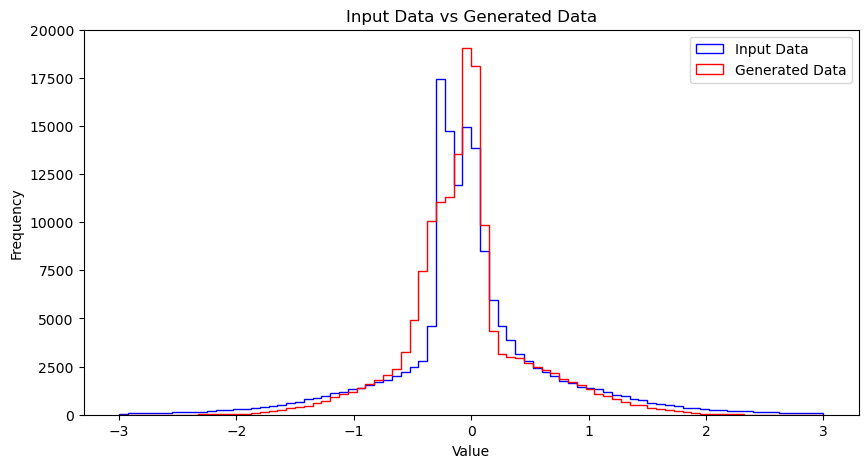

In [ ]:
with torch.no_grad():
    z = torch.randn(tensor_data.size(0), best_params['z_dim']).to(device)  # Gerar amostras com o mesmo tamanho dos dados de entrada
    generated_data = model.decoder(z, c_data)

plt.figure(figsize=(10, 5))
plt.hist(normalize(tensor_data).numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='blue', label='Input Data')
plt.hist(generated_data.numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='red', label='Generated Data')
plt.title('Input Data vs Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import scipy.stats as stats
# Teste de Kolmogorov-Smirnov
train_recon_ks = stats.ks_2samp(x_train.numpy().flatten(), recon_train.numpy().flatten())
test_recon_ks = stats.ks_2samp(x_test.numpy().flatten(), recon_test.numpy().flatten())
input_generated_ks = stats.ks_2samp(tensor_data.numpy().flatten(), generated_data.numpy().flatten())

print(f"KS test for Train vs. Reconstructed Train: statistic={train_recon_ks.statistic}, p-value={train_recon_ks.pvalue}")
print(f"KS test for Test vs. Reconstructed Test: statistic={test_recon_ks.statistic}, p-value={test_recon_ks.pvalue}")
print(f"KS test for Input vs. Generated: statistic={input_generated_ks.statistic}, p-value={input_generated_ks.pvalue}")

KS test for Train vs. Reconstructed Train: statistic=0.37265624999999997, p-value=0.0
KS test for Test vs. Reconstructed Test: statistic=0.37221875000000004, p-value=0.0
KS test for Input vs. Generated: statistic=0.36654375, p-value=0.0


Abaixo, iremos desnormalizar os dados para gerar plots com a distribuição original, retomando a problemática da distribuição dos momentos tranversais dos píons e dos kaons.

In [ ]:
# Desnormalizar os dados reconstruídos e gerados
with torch.no_grad():
    # Reconstrução dos dados de treino
    recon_train, _, _ = model(normalize(x_train).float(), c_train)
    recon_train = denormalize(recon_train.cpu())

    # Reconstrução dos dados de teste
    recon_test, _, _ = model(normalize(x_test).float(), c_test)
    recon_test = denormalize(recon_test)

    # Geração de novos dados
    z = torch.randn(tensor_data.size(0), best_params['z_dim']).to(device)
    generated_data = model.decoder(z, c_data)
    generated_data = denormalize(generated_data.cpu())

Amostra do VAE tentando reproduzir o dataset de treino (dados desnormalizados)

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(x_train.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='blue', label='Train Data')
plt.hist(recon_train.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='green', label='Reconstructed Train Data')
plt.title('Train Data vs Reconstructed Train Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando reproduzir o dataset de teste (dados desnormalizados)

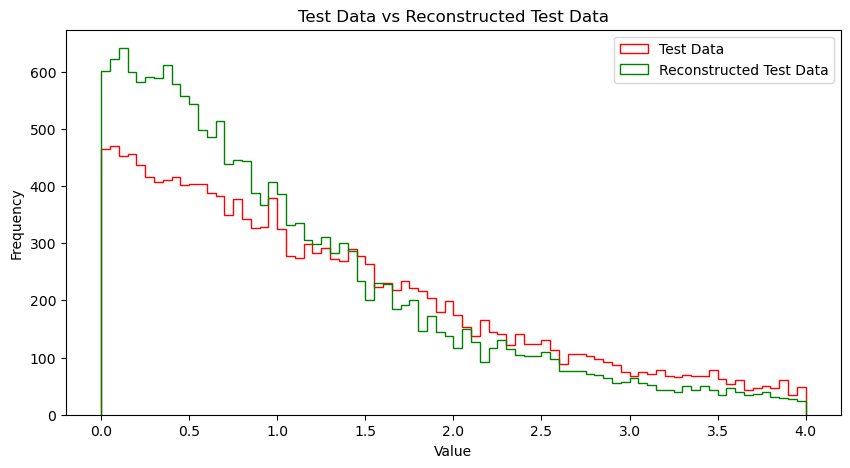

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(x_test.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='red', label='Test Data')
plt.hist(recon_test.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='green', label='Reconstructed Test Data')
plt.title('Test Data vs Reconstructed Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando gerar novos dados que seguem a mesma distribuição do input (dados desnormalizados)

In [ ]:
# PLOTS FUNCTION

def subplot_trk(data, generated, trk):
    if trk == "trk1":
        id_list = [0, 2, 4, 6]
        name_list = ["Kaons x component momentum (Px)", "Kaons y component momentum (Py)", "Kaons z component momentum (Pz)", "Kaons energy (E)"]
    if trk == "trk2":
        id_list = [1, 3, 5, 7]
        name_list = ["Pions x component momentum (Px)", "Pions y component momentum (Py)", "Pions z component momentum (Pz)", "Pions energy (E)"]
    if trk == "both":
        data_tensor = torch.zeros([2*data.size()[0], 4])
        gen_tensor = torch.zeros([2*data.size()[0], 4])
        data_tensor[:, 0], gen_tensor[:, 0] = data[:, :2].flatten(), generated[:, :2].flatten()
        data_tensor[:, 1], gen_tensor[:, 1] = data[:, 2:4].flatten(), generated[:, 2:4].flatten()
        data_tensor[:, 2], gen_tensor[:, 2] = data[:, 4:6].flatten(), generated[:, 4:6].flatten()
        data_tensor[:, 3], gen_tensor[:, 3] = data[:, 6:8].flatten(), generated[:, 6:8].flatten()
        data, generated = data_tensor, gen_tensor
        id_list = [0, 1, 2, 3]
        name_list = ["Px1+Px2", "Py1+Py2", "Pz1+Pz2", "E1+E2"]
        
    range_list = [[-5, 5], [-5, 5], [-10, 10], [0, 20]]
    
    plt.figure(figsize=(10,10))
    for i in range(len(id_list)):
        plt.subplot(2, 2, i+1)
        plt.hist(data[:, id_list[i]].numpy().flatten(), bins=80, range=range_list[i], histtype='step', color='blue', label='Input Data')
        plt.hist(generated[:, id_list[i]].numpy().flatten(), bins=80, range=range_list[i], histtype='step', color='red', label='Generated Data')
        plt.title(f'{name_list[i]}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

    return plt.show()

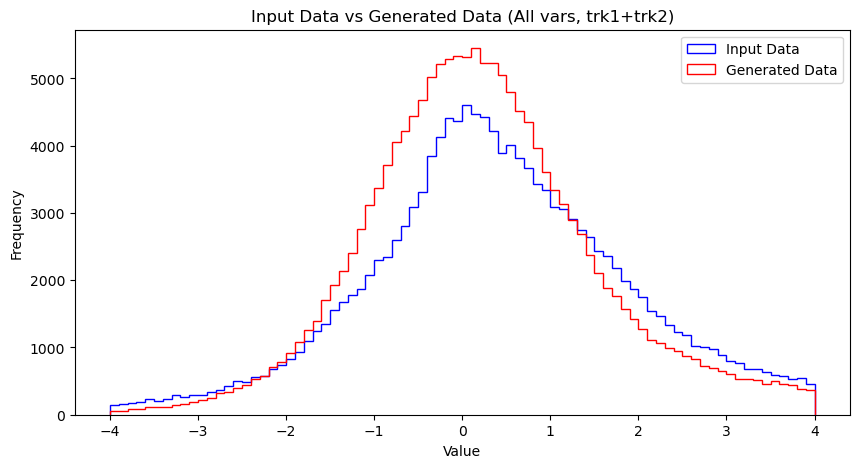

torch.Size([20000, 8])


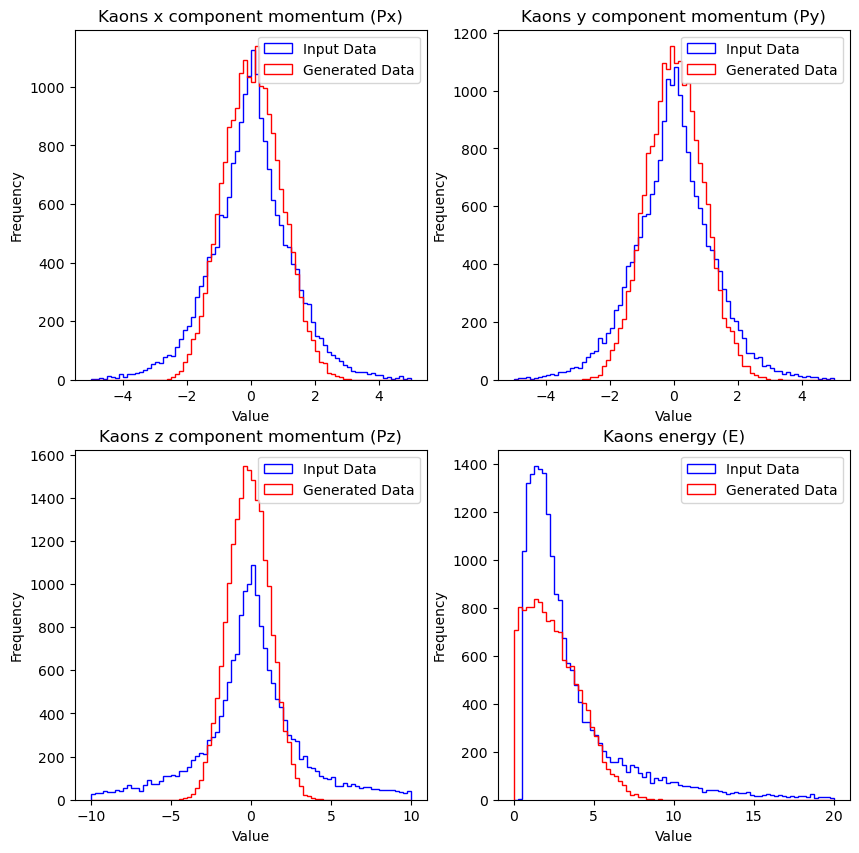

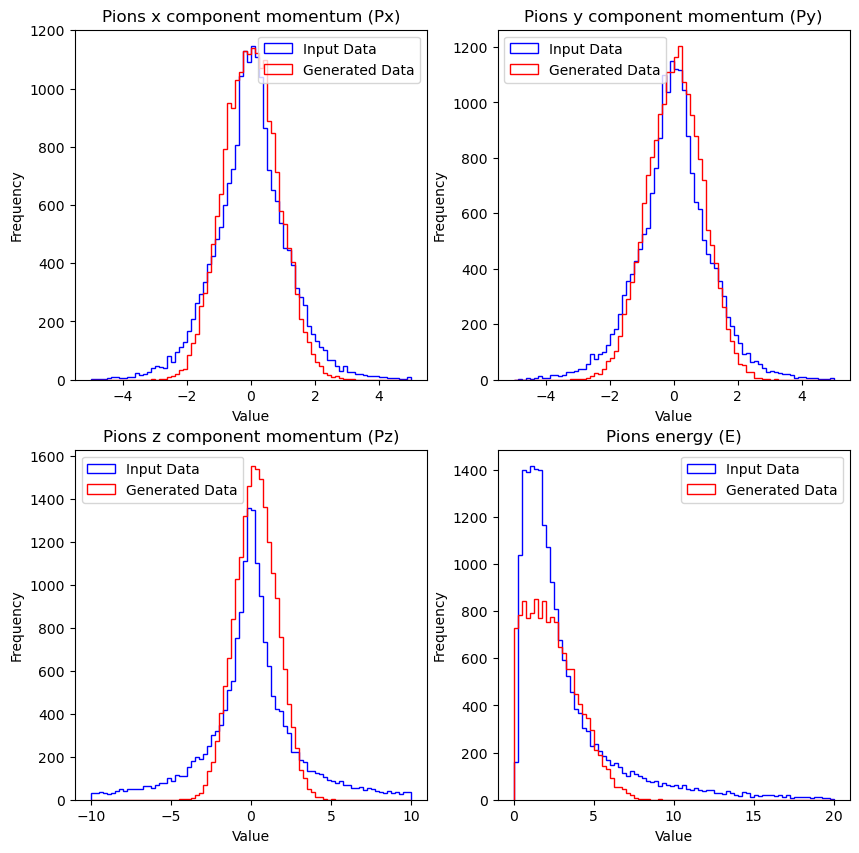

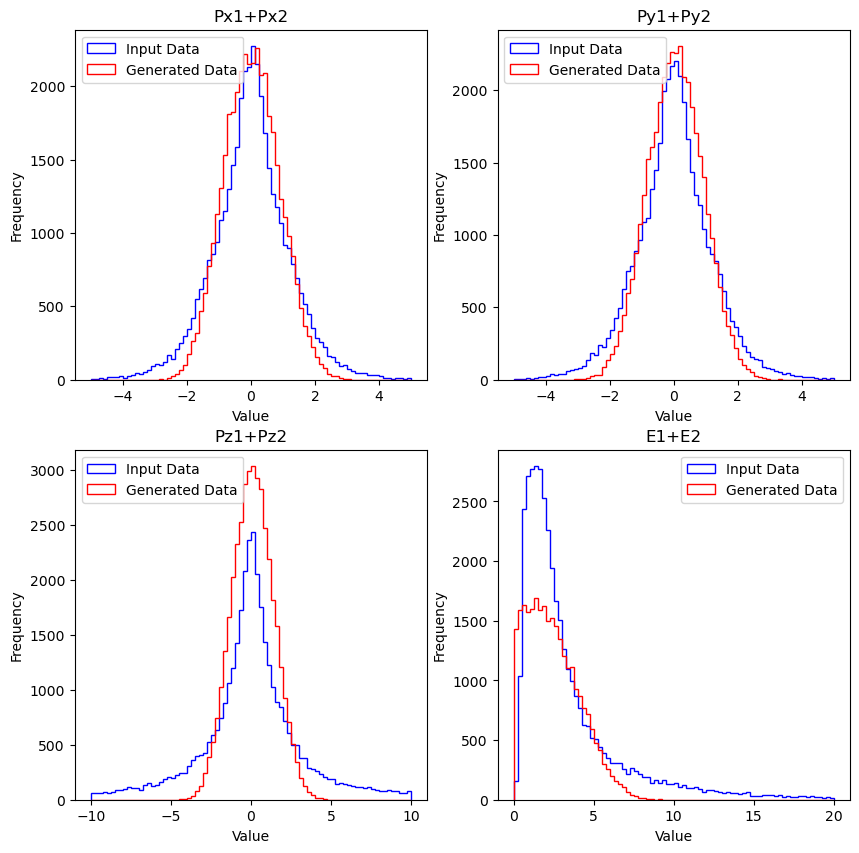

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(tensor_data.flatten(), bins=80, range=[-4, 4], histtype='step', color='blue', label='Input Data')
plt.hist(generated_data.flatten(), bins=80, range=[-4, 4], histtype='step', color='red', label='Generated Data')
plt.title('Input Data vs Generated Data (All vars, trk1+trk2)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(tensor_data.size())
subplot_trk(tensor_data, generated_data, "trk1")
subplot_trk(tensor_data, generated_data, "trk2")
subplot_trk(tensor_data, generated_data, "both")

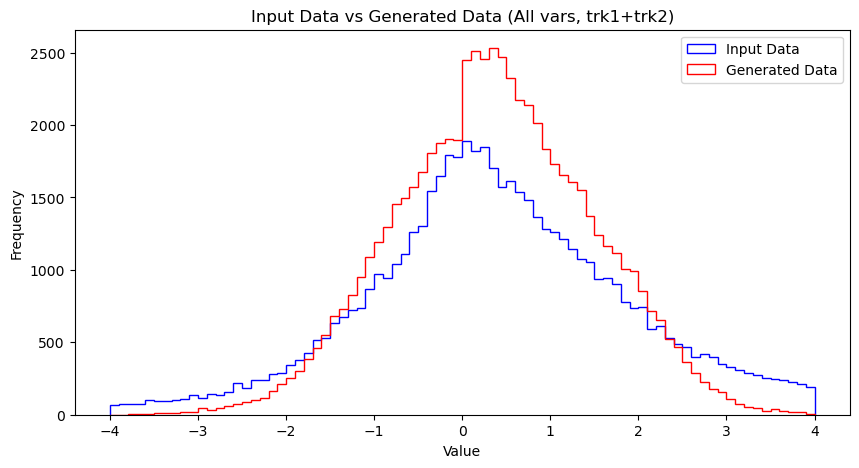

torch.Size([8076, 8])


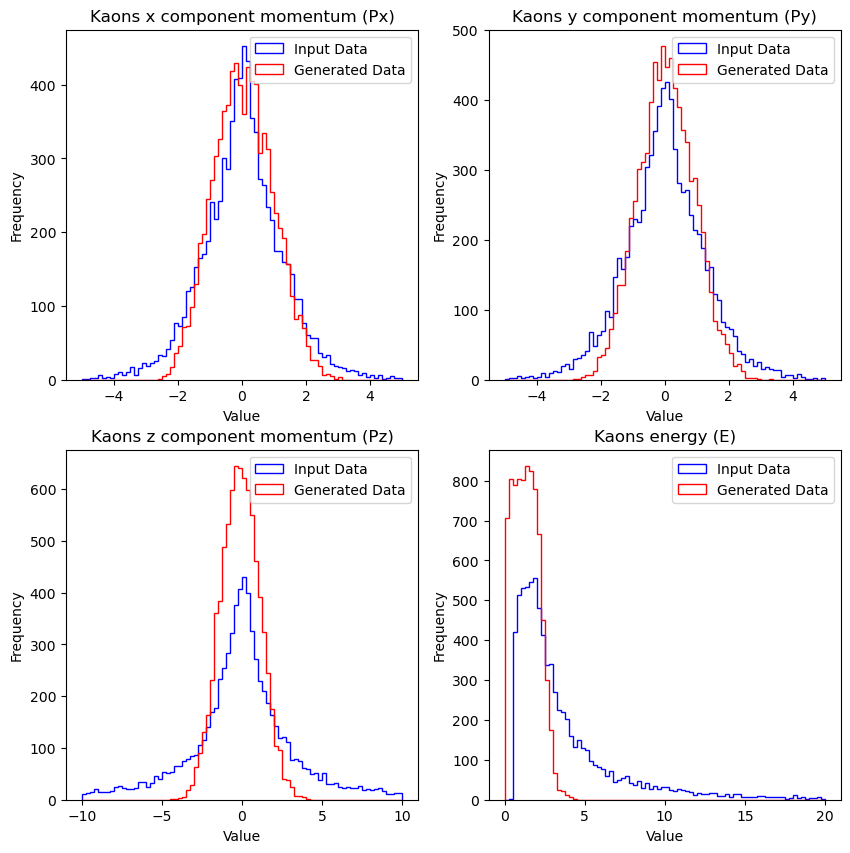

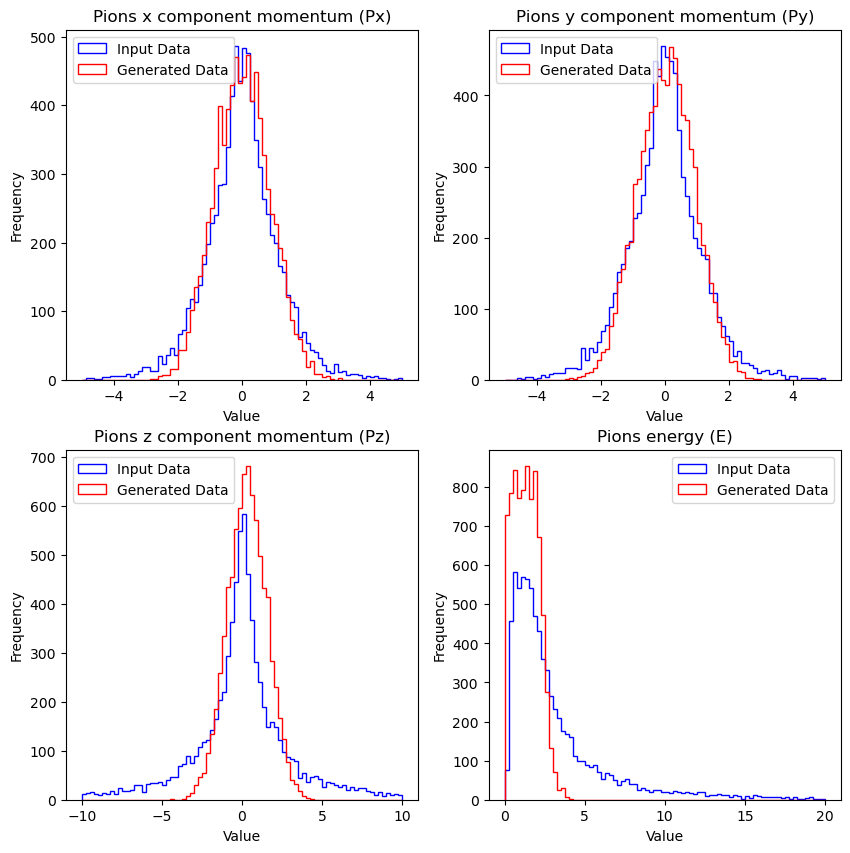

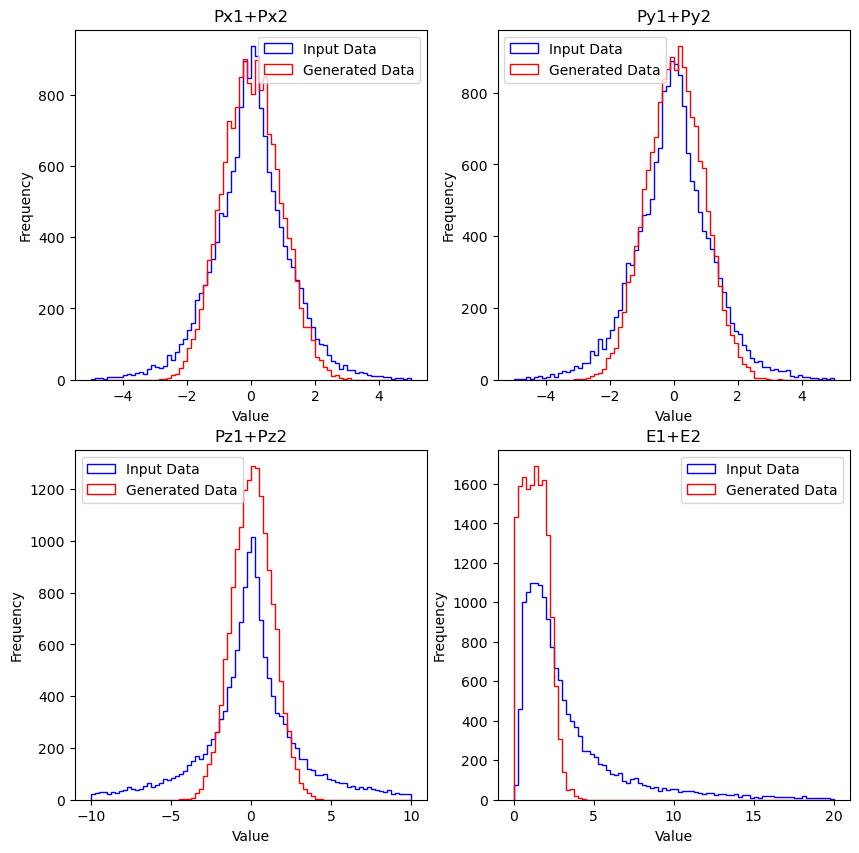

In [ ]:
generated_px = generated_data[:, 0] + generated_data[:, 1]
generated_py = generated_data[:, 2] + generated_data[:, 3]
generated_pz = generated_data[:, 4] + generated_data[:, 5]
generated_E = generated_data[:, 6] + generated_data[:, 7]

mass_mask = (torch.sqrt(generated_E**2 - generated_px**2 - generated_py**2 - generated_pz**2) > 0)
energies_mask = ((generated_data[:, 6] > 0) & (generated_data[:, 7] > 0))
physical_mask = (mass_mask & energies_mask)
filtered_generated_data = generated_data[physical_mask]
filtered_tensor_data = tensor_data[physical_mask]

plt.figure(figsize=(10, 5))
plt.hist(filtered_tensor_data.flatten(), bins=80, range=[-4, 4], histtype='step', color='blue', label='Input Data')
plt.hist(filtered_generated_data.flatten(), bins=80, range=[-4, 4], histtype='step', color='red', label='Generated Data')
plt.title('Input Data vs Generated Data (All vars, trk1+trk2)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(filtered_tensor_data.size())
subplot_trk(filtered_tensor_data, filtered_generated_data, "trk1")
subplot_trk(filtered_tensor_data, filtered_generated_data, "trk2")
subplot_trk(filtered_tensor_data, filtered_generated_data, "both")

Abaixo, é rodado um teste de Kolmogorov-Smirnov para analisar a proximidade dos dois hitogramas em cada gráfico (apenas para as distribuições desnormalizadas). Uma das métricas de interesse é o p-valor.

P-Valor Significativo: um p-valor abaixo de 0.05 é frequentemente considerado significativo, o que indica que a hipótese nula (de que as distribuições são iguais) pode ser rejeitada.

P-Valor Não Significativo: Um p-valor acima de 0.05 geralmente sugere que não há evidência suficiente para rejeitar a hipótese nula. Valores como 0.10, 0.15, ou mais altos são interpretados como indicando uma falta de diferença significativa entre as distribuições.

P-Valor > 0.05: Indica que não há uma diferença significativa entre as distribuições comparadas. Esse é um bom sinal, sugerindo que as distribuições dos dados gerados ou reconstruídos são semelhantes aos dados reais.

P-Valor > 0.10 ou 0.15: Indica uma forte semelhança entre as distribuições, o que é ótimo.

In [ ]:
import scipy.stats as stats
# Teste de Kolmogorov-Smirnov
train_recon_ks = stats.ks_2samp(x_train.flatten(), recon_train.flatten())
test_recon_ks = stats.ks_2samp(x_test.flatten(), recon_test.flatten())
input_generated_ks = stats.ks_2samp(tensor_data.flatten(), generated_data.flatten())

print(f"KS test for Train vs. Reconstructed Train: statistic={train_recon_ks.statistic}, p-value={train_recon_ks.pvalue}")
print(f"KS test for Test vs. Reconstructed Test: statistic={test_recon_ks.statistic}, p-value={test_recon_ks.pvalue}")
print(f"KS test for Input vs. Generated: statistic={input_generated_ks.statistic}, p-value={input_generated_ks.pvalue}")

KS test for Train vs. Reconstructed Train: statistic=0.1313333333333333, p-value=0.0
KS test for Test vs. Reconstructed Test: statistic=0.13168750000000007, p-value=2.1139765699402536e-242
KS test for Input vs. Generated: statistic=0.11408125000000002, p-value=0.0


In [ ]:
print(mass_func(filtered_generated_data).mean())

tensor(4.2155, dtype=torch.float64)
